<a href="https://colab.research.google.com/github/Annie00000/Project/blob/main/12_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data

In [ ]:
from sklearn.model_selection import train_test_split
import os
import glob
import pandas as pd
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 設定資料路徑和目標圖片大小
data_dir = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/train/'
target_size = (224, 224)

# 讀取所有圖片路徑和標籤
image_paths = []
labels = []

for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_folder_path):
        for image_path in glob.glob(os.path.join(class_folder_path, '*.jpg')):  # 假設所有圖片都是jpg格式
            image_paths.append(image_path)
            labels.append(class_folder)

# 將標籤轉換為數字
label_to_index = dict((name, index) for index, name in enumerate(np.unique(labels)))
labels = np.array([label_to_index[label] for label in labels])

# 切分成訓練集、驗證集和測試集
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25)


In [ ]:
# 創建一個 DataFrame 從 label_to_index
label_to_index_df = pd.DataFrame(list(label_to_index.items()), columns=['Label', 'Index'])

# 將 DataFrame 寫入 CSV 檔案
#label_to_index_df.to_csv('label_to_index.csv', index=False)

# 確認已成功保存
print("Label to Index DataFrame 已成功保存為 label_to_index.csv 檔案。")

Label to Index DataFrame 已成功保存為 label_to_index.csv 檔案。


## 可視化圖片

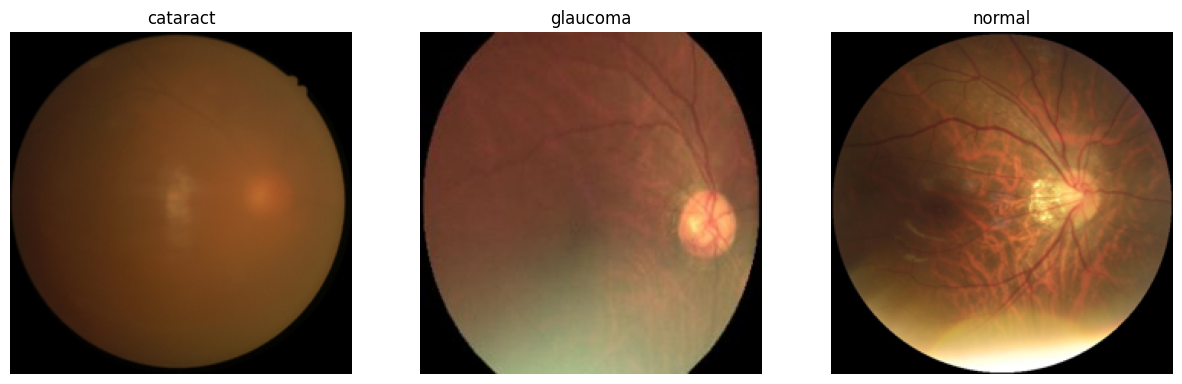

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(image_paths, labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 7))
    for i, label in enumerate(unique_labels):
        sample_path = np.random.choice(np.array(image_paths)[labels == label])
        image = Image.open(sample_path).resize(target_size)
        plt.subplot(1, len(unique_labels), i + 1)
        plt.imshow(image)
        plt.title(list(label_to_index.keys())[list(label_to_index.values()).index(label)])
        plt.axis('off')
    plt.show()

show_sample_images(train_paths, train_labels)

## 資料增強

In [9]:
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 讀取 CSV 檔案
augmentation_csv_path = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/augmentation.csv'
augmentation_rules = pd.read_csv(augmentation_csv_path)

# 定義資料增強函數
def apply_augmentation(image, label):
    rule = augmentation_rules[augmentation_rules['label'] == label].iloc[0]

    if rule['rotate 90'] == 1 and random.choice([True, False]):
        image = image.rotate(90, expand=True)
    if rule['rotate 180'] == 1 and random.choice([True, False]):
        image = image.rotate(180, expand=True)
    if rule['rotate 270'] == 1 and random.choice([True, False]):
        image = image.rotate(270, expand=True)
    if rule['水平翻轉'] == 1 and random.choice([True, False]):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    if rule['垂直翻轉'] == 1 and random.choice([True, False]):
        image = image.transpose(Image.FLIP_TOP_BOTTOM)

    return image

# 創建 ImageDataGenerator 並應用資料增強
data_gen_augmented = ImageDataGenerator(
    preprocessing_function=apply_augmentation,
    rescale=1./255
)

# 創建資料生成器
train_data_augmented = data_gen_augmented.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'  # 用於訓練數據
)

Found 4285 images belonging to 4 classes.


## 可視化 增強後圖片

In [10]:
def show_augmented_samples(generator, num_samples=5):
    plt.figure(figsize=(15, 7))
    for i in range(num_samples):
        image, _ = next(generator)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image[0])
        plt.title(f'Sample {i + 1}')
        plt.axis('off')
    plt.show()

# 顯示經過資料增強後的一些圖片
show_augmented_samples(train_data_augmented)

TypeError: ignored

<Figure size 1500x700 with 0 Axes>

## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt

# 定義 DenseNet 模型

def create_densenet_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False)
    # base_model = DenseNet121(weights='path_to_local_weights_file', include_top=False)  無法下載預訓練的，先去load weight
    # base_model = DenseNet121(weights=None, include_top=False)  直接用初始的

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# 設定超參數
num_classes = len(label_to_index)  # 類別數量等於索引數量
batch_size = 32
epochs = 20

# 創建 DenseNet 模型
model = create_densenet_model(num_classes)

# 編譯模型
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 設定回調函數
checkpoint = ModelCheckpoint('densenet_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=5, verbose=1)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
# 總之，TensorBoard 幫助您監控模型的訓練過程、可視化模型的性能以及調試模型。您可以根據需要調整上述參數來控制日誌文件的生成方式。

# 訓練模型
history = model.fit(
    train_data_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_data_generator,  # 假設已經定義了驗證集的資料生成器
    callbacks=[checkpoint, early_stopping, tensorboard]
)

# 繪製訓練和驗證的準確度和損失圖表
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 使用測試集評估模型
test_loss, test_accuracy = model.evaluate(test_data_generator)  # 假設已經定義了測試集的資料生成器
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

#### 查看分錯的圖片

In [ ]:
import numpy as np

# 使用 os.listdir 獲取子目錄，每個子目錄名稱即為一個類別名稱
class_names = os.listdir(data_dir)

# 如果您需要按特定順序排序類別名稱，您可以使用 sorted 函數
class_names = sorted(class_names)

# 初始化一個字典來記錄每個類別的分錯數量
class_miscounts = {class_name: 0 for class_name in class_names}

# 初始化一個列表來記錄分錯的圖片資訊
misclassified_images = []

# 遍歷測試集並進行預測
for i, (images, labels) in enumerate(test_data_generator):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    for j in range(len(labels)):
        true_label = np.argmax(labels[j])
        predicted_label = predicted_labels[j]

        # 如果預測錯誤，則將分錯數量增加1，並將圖片資訊添加到列表中
        if true_label != predicted_label:
            class_name = class_names[true_label]
            class_miscounts[class_name] += 1
            misclassified_images.append({
                'True_Label': class_name,
                'Predicted_Label': class_names[predicted_label],
                'Image': images[j]  # 如果需要存儲圖片本身，可以這樣做
            })

# 輸出每個類別的分錯數量
for class_name, miscount in class_miscounts.items():
    print(f'Class: {class_name}, Misclassified Count: {miscount}')

# 查看分錯的圖片
for misclassified_image in misclassified_images:
    true_label = misclassified_image['True_Label']
    predicted_label = misclassified_image['Predicted_Label']
    image = misclassified_image['Image']

    # 可以根據需要顯示或儲存分錯的圖片，這裡只是一個示例
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()